In [1]:
import os
os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/R'
import rpy2
from utils import *
import pingouin as pg
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from concurrent.futures import ThreadPoolExecutor, as_completed
# get some functions for the behavior analyses
import sys
sys.path.append('../behavior')
from fnc_analysis import (two_bottle_plot, cumm_test_licks_plot, check_significance,
                          two_bottle_pref_plot_vl, plot_significance)
from concurrent.futures import ThreadPoolExecutor, as_completed

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
%%R
library(lme4)
library(lmerTest)
library(splines)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [3]:
#figure settings
mpl.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('Set1',10))
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
# figure save paths
first_lick_pdfs = os.path.join('figures', 'training', 'full-trace', 'first-lick', 'pdfs')
first_lick_svgs = os.path.join('figures', 'training', 'full-trace', 'first-lick', 'svgs')

peri_stim_pdfs_train =  os.path.join('figures', 'training', 'peri-stim', 'pdfs')
peri_stim_svgs_train =  os.path.join('figures', 'training', 'peri-stim', 'svgs')
peri_stim_train_figs =  os.path.join('figures', 'training', 'peri-stim')

peri_stim_pdfs_test = os.path.join('figures', 'testing', 'peri-stim', 'pdfs')
peri_stim_svgs_test = os.path.join('figures', 'testing', 'peri-stim', 'svgs')
peri_stim_test_figs = os.path.join('figures', 'testing', 'peri-stim')

first_lick_test_pdfs = os.path.join('figures', 'testing', 'full-trace', 'pdfs')
first_lick_test_svgs =  os.path.join('figures', 'testing', 'full-trace',  'svgs')

methods_pdfs = os.path.join('figures', 'methods', 'pdfs')
methods_svgs = os.path.join('figures', 'methods', 'svgs')

fig_paths = [ first_lick_pdfs, first_lick_svgs,
              peri_stim_train_figs,
              peri_stim_pdfs_train, peri_stim_svgs_train,
              peri_stim_test_figs,
              peri_stim_pdfs_test, peri_stim_svgs_test,
              first_lick_test_pdfs, first_lick_test_svgs,
              methods_pdfs, methods_svgs ]

for i in fig_paths:
    os.makedirs(i, exist_ok=True)         


main_train_fig_stats = {}
main_test_fig_stats = {}

cohort1_data_dir = Path("../../data/photometry/cohort1")
cohort2_data_dir = Path("../../data/photometry/cohort2")
data_dir = Path("../../data/photometry")

In [5]:
# analysis parameters
# preprocessing
ds_freq = 10                              # frequency to downsample to
ex = 10                                   # number of standard deviations beyond which to exclude data points (i.e. artifact)
t_dur = 1800                              # total duration of each session in seconds from spout presentation
norm_method = norm_to_median_pre_stim     # normalization method, see functions in the utilities file in  our photometry scripts
detrend = True                            # whether or not to regress out motion and photobleaching artifact using the 405
detrend_method = detrend_405_constrained  # method for artifact removal. constrained means we only regress out positive correlations between the 470 and 405


# peri-bout
bout_thresh = 20                          # inter-lick-interval threshold for defining a new bout
niters_rand = 100                         # number of iterations over which generate random bouts
peri_window = 15                          # duration in seconds flanking the bout onset to analyze peri-bout responses
peri_bout_norm_train = "none"             # method for normalizing peri-bout responses during training
peri_bout_norm_test  = "none"             # method for normalizing peri-bout responses during testing

# kernel parameters for moving average detrending
w_rad= 30
ksize = int(2* ds_freq * w_rad) + 1
kernel = signal.boxcar(ksize)/ksize
mice_to_drop = ['adm480', 'adm569'] 

### food drops

recomputing...
successful
recomputing...
successful


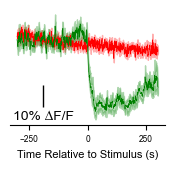

In [6]:
chow_fd = load_analysis('/Users/nathanielnyema/Downloads/fnc_agrp_project/data/photometry/analysis_FNC_fd2_adm571_adm551_adm569_adm567_adm543_adm546_adm484_adm480_adm485_adm445.npy', recompute= False)
chow_fd.norm = True
chow_fd.detrend =  False
# chow_fd.detrend_method = detrend_method
chow_fd.norm_method = norm_method
chow_fd.t_prestim = 300
chow_fd.compute()

bad_fd_mice = (chow_fd.ind_peak_df_f('min', pr = False)['min ∆F/F']>-.2).droplevel(0)
bad_fd_mice = bad_fd_mice.loc[bad_fd_mice].index
mice_to_drop = np.unique(bad_fd_mice.tolist() + mice_to_drop)

for i in mice_to_drop:
    chow_fd.remove_mouse(i, recompute = False)
chow_fd.compute()


fig, ax = plt.subplots(1,1, figsize = (2,1.5))
chow_fd.plot_both(ax=ax, show=False)

vertbar = AnchoredSizeBar(ax.transData,
                           1, '10% ∆F/F', 'lower left', 
                           pad=.1,
                           color='black',
                           frameon=False,
                           size_vertical=.1)
ax.add_artist(vertbar)
ax.tick_params(left=False,labelleft=False)
ax.set_ylabel('')
ax.xaxis.label.set_fontsize(8)
for i in ax.get_xticklabels():
    i.set_fontsize(6)

sns.despine(left = True)

fig.savefig('no_detrend.pdf')
fig.savefig( os.path.join(first_lick_pdfs, 'chow_fd.pdf') , transparent=True, bbox_inches='tight')
fig.savefig( os.path.join(first_lick_svgs, 'chow_fd.svg') , transparent=True, bbox_inches='tight')

## bout level analyses

Here we're interested in whether or not we can identify faster dynamics time-locked to the initiation of lick bouts. First we need to identify the onsets of lick bouts.

In [23]:
# load training data
training = analysis(norm_method, t_dur, norm = False,
                    ds_freq = ds_freq, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
training.load_append_save(cohort1_data_dir/'training.npy', log=False)
training.load_append_save(cohort2_data_dir/'training.npy', log=False)
for i in mice_to_drop:
    training.remove_mouse(i, recompute = False)
training.compute()

recomputing...
successful


In [24]:
# compute lick bout times for training
for i,v in training.raw_data.items():
    l = training.raw_data.loc[i].events['left_licks'] 
    ili = np.append(bout_thresh + 1, l[1:] - l[:-1])
    training.raw_data.loc[i].events['left_bouts'] = l[ili > bout_thresh]

# compute lick rates during training
lr_train = get_lick_rate(training, 'left_licks', sigma = .4, win = 2)
peri_bout_lr = peri_event(training, 'left_bouts', peri_window, df = lr_train)
peri_bout_lr = reindex(peri_bout_lr) 

In [25]:
orig_training = deepcopy(training) # keep a version before detrending

# remove timestamps corresponding to datapoints that will be lost to the moving average
old_t = training.all_490.index.values
new_t = old_t[int(ds_freq * w_rad):-int(ds_freq *w_rad)]

# estimate the baseline with a moving average
bl = training.all_490.apply(lambda x: pd.Series(signal.convolve(x, kernel, mode='valid'), index = new_t), axis=0)

# update the end and start time fields in the analysis object
training.t_prestim = -new_t[0]
training.t_endrec = new_t[-1]
training.all_490 = training.all_490.loc[bl.index]

# normalize relative to the baseline
training.all_490 = (training.all_490.copy() - bl)/bl

# #z-score ∆F/Fs relative to baseline activity for each session
training.all_490 = (training.all_490 - training.all_490.loc[:0].mean(axis=0))/training.all_490.loc[:0].std(axis=0)

### extracting peri-lick bout activity

In [317]:
# get peri-bout activity for all bouts
bn= training.raw_data.apply(lambda x: get_bn(x, 'left_licks', 'left_bouts'))
for i in training.raw_data.index:
    # only include bouts with more than one lick
    training.raw_data[i].events['valid_bouts'] = training.raw_data[i].events['left_bouts'][bn.loc[i].dropna().values>1]
bn = reindex(bn.droplevel('trial').T)
bn.columns.name = 'event'
peri_bout = peri_event(training, 'valid_bouts', peri_window, norm = peri_bout_norm_train)
peri_bout = reindex(peri_bout).loc[[1,3]]
mn_peri_bout = peri_bout.groupby(['day','cs','mouse']).mean()

### randomize

In [295]:
# simmulate random lick bouts and get corresponding peri bout activity
np.random.seed(32)
ctl = []

with tqdm(total = niters_rand) as pbar:
    def randomize_bouts(pid):
        global ctl_mn
        global training
        
        end_lim = training.all_490.index[-1]-peri_window-1
        for i,v in training.raw_data.items():
            # create an array of times to sample
            ts = np.arange(0, end_lim + 1/100, step = 1/100)
            n = v.events['valid_bouts'].size # get the number of bouts to sample
            rand_evs = np.empty((n,))

            for j in range(n):
                #choose a bout onset time from available times
                rand_evs[j] = np.random.choice(ts)
                # remove the selected time from avavilable times array
                # as well as any times within the bout threshold
                ts = ts[np.abs(ts - rand_evs[j]) > bout_thresh]  
            
            #save randomized bouts
            training.raw_data.loc[i].events[f'rand_bouts_{pid}'] = np.sort(rand_evs) 
            
        # get peri-bout data for random bouts and compute the mean response
        _d = peri_event(training, f'rand_bouts_{pid}', peri_window,norm = peri_bout_norm_test)
        _d = _d.groupby(['cond','mouse'], axis=1).mean()
        ctl.append(_d)

    with ThreadPoolExecutor(max_workers=2) as pool:
        futures = [pool.submit(randomize_bouts, i) for i in range(niters_rand)]
        for future in as_completed(futures):
            pbar.update(1)

ctl = reindex(pd.concat(dict(zip(range(len(ctl)), ctl)), 
                        axis=1, names = ['event']))
ctl_mn = ctl.groupby(['day','cs','mouse']).mean()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


### further quantification

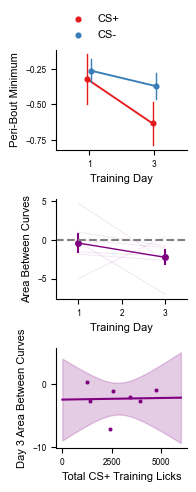

In [324]:
fig, ax = plt.subplots(3,1, figsize=(2,5))

# get min responses from 0 to 5s and plot
mn_loc =  mn_peri_bout.groupby(['day','cs']).mean().T.idxmin(axis=0)
mn_rp = {}
for i,v in mn_loc.items():
    tmp = mn_peri_bout.loc[i].T
    tmp.index = tmp.index.astype(float)
    mn_rp.update({i:tmp.loc[v-1:v+1].mean(axis=0)})
mn_rp = pd.DataFrame(mn_rp).T
mn_rp.index = mn_rp.index.set_names(['day', 'cs'])
mn_rp = mn_rp.stack().rename('df')

g = sns.pointplot(mn_rp.reset_index(), x='day', y='df',hue='cs',
                  scale=.5, errwidth=1,
                  errorbar='se',dodge=True, ax=ax[0])
g.legend(g.get_legend_handles_labels()[0], ['CS+', 'CS-'], fontsize=8,
         loc = 'lower left', bbox_to_anchor = (0,1), frameon = False)
g.set_xlabel("Training Day", fontsize=8)
g.set_ylabel("Peri-Bout Minimum", fontsize=8)

abc = mn_peri_bout.swaplevel('day','cs').loc['+'].T.loc[0:] - mn_peri_bout.swaplevel('day','cs').loc['-'].T.loc[0:]
abc = abc.apply(lambda x: np.trapz(x.values, x=x.index), axis=0)#/mn_peri_bout.swaplevel('day','cs').loc['-'].std(axis=1)
abc = abc.rename('df').reset_index() # mn_peri_bout.swaplevel('day','cs').loc['-'].std(axis=1)
# abc = mn_rp.unstack('cs').apply(lambda x: x['+'] - x['-'], axis=1).rename('df').reset_index()

sns.lineplot(abc, x='day',y='df', errorbar='se', marker='o', markeredgewidth=0, 
             color = 'purple', err_style='bars', markersize=5, linewidth=1,
             ax=ax[1])
g = sns.lineplot(abc, x='day',y='df', errorbar='se', 
                 palette=['purple']*abc.mouse.unique().size,
                 hue='mouse',
                 ax=ax[1], alpha=0.1, linewidth=.7)
g.get_legend().remove()
ax[1].axhline(0, c = 'gray', ls = '--')
ax[1].set_ylabel("Area Between Curves", fontsize=8)
ax[1].set_xlabel("Training Day", fontsize=8)
ax[1].set_xlim(0.5,3.5)
ax[1].set_xticks(np.arange(1,4))

diff_d3 = abc.set_index(['day','mouse']).df.loc[3]
train_licks = reindex(training.raw_data.apply(lambda x: x.events['left_licks'].size).droplevel('trial'))[0]
train_licks = train_licks.groupby(['mouse','cs']).sum().loc[:, '+'].loc[diff_d3.index]
df = pd.concat({'licks':train_licks, 'diff': diff_d3}, axis=1)
d3vlicks = smf.ols('diff ~ licks', df).fit()
x = np.linspace(0,6000, 100)

pred = d3vlicks.get_prediction({'licks': x})
sns.scatterplot(data=df, x='licks', y='diff', ax = ax[2], s=10, color = 'purple')
ax[2].plot(x, pred.predicted_mean, c='purple')
ax[2].fill_between(x, pred.conf_int()[:,0], pred.conf_int()[:,1], color = 'purple', alpha = 0.2)
ax[2].set_xlabel('Total CS+ Training Licks', fontsize=8)
ax[2].set_ylabel(r"Day 3 Area Between Curves", fontsize=8)

for i in range(3):
    for j in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        j.set_fontsize(6)



# format figure
sns.despine()
fig.tight_layout(pad = 1.)

# # save figure
fig.savefig(os.path.join(peri_stim_pdfs_train ,'additional_quantification.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_train ,'additional_quantification.svg'))


#### stats

##### stats - minimum response

,F Value,Num DF,Den DF,Pr > F,Significance
cs,2.012678,1.0,6.0,0.205783,ns
day,4.739370,1.0,6.0,0.072359,ns
cs:day,1.920809,1.0,6.0,0.215080,ns


,t,p-value,df,Corrected p-value,Significance
day,,,,,
1,-0.409539,0.696363,6.0,0.696363,ns
3,-2.166802,0.073385,6.0,0.141385,ns


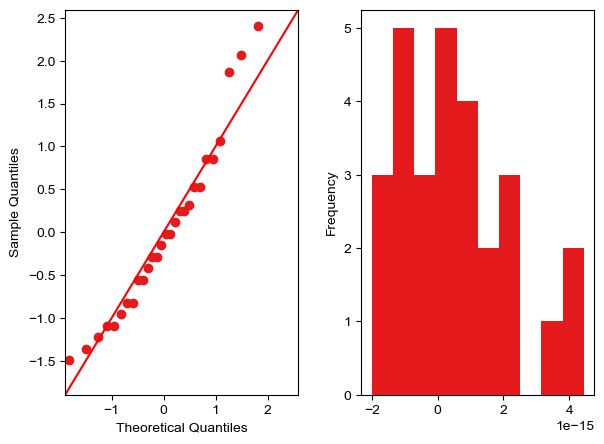

In [325]:
# fit the anova
mn_rp_anova = AnovaRM(mn_rp.reset_index(), 'df', 'mouse', 
                      within=['cs','day']).fit().summary().tables[0]
mn_rp_anova['Significance'] = mn_rp_anova['Pr > F'].apply(check_significance)

# validate normal residuals
resid = smf.ols('day~C(cs,Sum)*C(day,Sum)*C(mouse,Sum)', 
                mn_rp.reset_index()).fit().resid

fig, ax = plt.subplots(1,2)
sm.qqplot(resid, fit=True, line='45', ax = ax[0]);
resid.plot.hist(ax=ax[1])
fig.tight_layout(pad = 2.)

mn_rp_stats = mn_rp.unstack('cs').groupby('day').apply(lambda x: st.ttest_rel(x['+'], x['-'])).apply(lambda x: pd.Series(list(x) + [x.df], index = ('t', 'p-value', 'df')))
mn_rp_stats['Corrected p-value'] = multipletests(mn_rp_stats['p-value'], method='holm-sidak')[1]
mn_rp_stats['Significance'] = mn_rp_stats['Corrected p-value'].apply(check_significance)

display(mn_rp_anova, mn_rp_stats)
main_train_fig_stats.update({'h_min_resp_anova': mn_rp_anova,
                             'h_min_resp_stats': mn_rp_stats})

##### stats - area between curves correlation

In [227]:
# fit the anova

abc_friedman = st.friedmanchisquare(abc.set_index(['day','mouse']).loc[1].df, 
                                    abc.set_index(['day','mouse']).loc[2].df,
                                    abc.set_index(['day','mouse']).loc[3].df)

abc_friedman = pd.Series(abc_friedman, index=('statistic', 'p-value')).rename('ABC Friedman Test').to_frame().T
abc_friedman['Significance'] = abc_friedman['p-value'].apply(check_significance)


abc_stats = (abc.set_index(['day','mouse'])
                .loc[[1,3]]
                .groupby('day').df
                .apply(lambda x: st.ttest_1samp(x, 0))
                .apply(lambda x: pd.Series(x, index=('W', 'p-value')))
            )
abc_stats['Corrected p-value'] = multipletests(abc_stats['p-value'], method='holm-sidak')[1]
abc_stats['Significance'] = abc_stats['Corrected p-value'].apply(check_significance)

display(abc_friedman, abc_stats)
main_train_fig_stats.update({'i_ABC_friedman': abc_friedman,
                             'i_ABC_stats': abc_stats})

,statistic,p-value,Significance
ABC Friedman Test,0.285714,0.866878,ns


,W,p-value,Corrected p-value,Significance
day,,,,
1,-1.158253,0.290776,0.290776,ns
3,-2.166802,0.073385,0.141385,ns


In [217]:
abc.set_index(['day','mouse']).loc[[1,3]]

df
day mouse           
1   adm484 -4.999046
    adm485 -1.856997
    adm543 -1.568208
    adm546  0.045151
    adm551 -0.241203
    adm567  1.006499
    adm571  4.726979
3   adm484  0.423343
    adm485 -2.661093
    adm543 -2.065640
    adm546 -1.023775
    adm551 -7.028115
    adm567 -0.802488
    adm571 -2.670903

##### stats - area between curves correlation

In [40]:
d3vlicks_coef = pd.DataFrame(d3vlicks.summary().tables[1])
d3vlicks_coef.columns = d3vlicks_coef.iloc[0].astype(str)
d3vlicks_coef = d3vlicks_coef.set_index('').iloc[1:]
d3vlicks_r = pd.Series({'R2': d3vlicks.rsquared}).rename("Day 3 ABC vs Cummulative Training Licks Correlation").to_frame().T

display(d3vlicks_coef, d3vlicks_r)

main_train_fig_stats.update({'j_d3_ABC_lick_corr_coef': d3vlicks_coef,
                             'j_d3_ABC_lick_corr_r2': d3vlicks_r})

/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,-3.5671,0.867,-4.116,0.009,-5.795,-1.339
licks,0.0008,0.000,2.926,0.033,0.000,0.002


,R2
Day 3 ABC vs Cummulative Training Licks Correlation,0.631376


In [41]:
with pd.ExcelWriter('stats/raw/train_stats.xlsx') as writer:  
    for k,v in main_train_fig_stats.items():
        v.to_excel(writer, sheet_name=k)

### (supplemental) - within session analysis

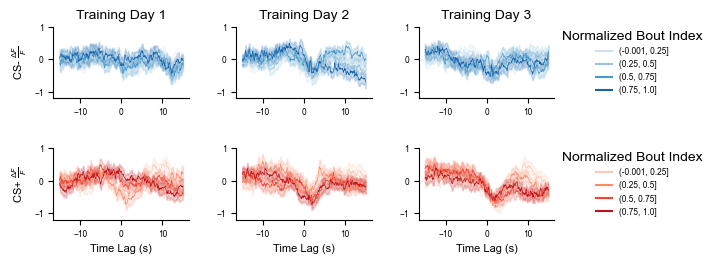

In [42]:
fig, ax = plt.subplots(2,3, figsize=(6,3))

df = peri_bout.stack().rename('df').reset_index()
df['bout_fraction'] = df.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/(x.max()))
df['bout_frac_bin'] = pd.cut(df.bout_fraction, np.arange(0,1.001, 0.25), include_lowest=True)

for i in range(3):
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='-')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Blues', ax=ax[0,i], legend=False if i<2 else True, linewidth=.5)
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='+')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Reds', markeredgewidth=0, ax = ax[1,i], legend=False if i<2 else True, linewidth=.5)
    ax[0,i].set_ylim(-1.2,1)
    ax[1,i].set_ylim(-1.2,1)
    ax[0,i].set_title(f"Training Day {i+1}", fontsize=10)
    ax[0,i].set_ylabel("")
    ax[1,i].set_ylabel("")
    ax[0,i].set_xlabel("")
    ax[1,i].set_xlabel("Time Lag (s)", fontsize=8)
    for j in ax[0,i].get_xticklabels() + ax[0,i].get_yticklabels():
        j.set_fontsize(6)
    for j in ax[1,i].get_xticklabels() + ax[1,i].get_yticklabels():
        j.set_fontsize(6)

ax[0,0].set_ylabel(r"CS- $\frac{\Delta F}{F}$", fontsize=8)
ax[1,0].set_ylabel(r"CS+ $\frac{\Delta F}{F}$", fontsize=8)
sns.despine()
fig.tight_layout(pad=2)


ax[0,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index", fontsize=6)
ax[1,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index", fontsize=6)

fig.savefig(os.path.join(peri_stim_pdfs_train ,'supp_within_session.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_train ,'supp_within_session.svg'))

#### stats

##### stats - day 1

In [193]:
peri_binned['bout_fraction'] = peri_binned.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/x.max())
peri_binned['bout_frac_bin'] = pd.cut(peri_binned.bout_fraction, np.arange(0,1.001, 0.25), include_lowest=True).astype(str)
peri_binned['bout_frac_bin'].iloc[0]
day1_binned = peri_binned.loc[peri_binned.day==1]

R[write to console]: boundary (singular) fit: see help('isSingular')



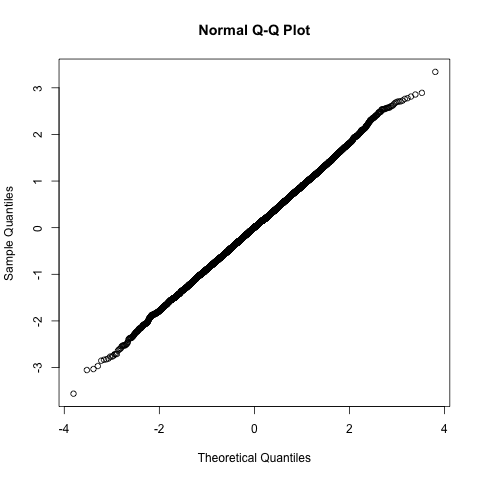

In [194]:
%%R -i day1_binned -o day1_anova -o day1_model
m <- lmer('df ~ 1+ factor(bout_frac_bin)*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=day1_binned)
day1_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
day1_anova <- anova(m)

In [198]:
day1_anova['Significance'] = day1_anova['Pr(>F)'].apply(check_significance)
day1_model['Significance'] = day1_model['Pr(>|t|)'].apply(check_significance)

display(day1_anova, day1_model)
day1_model.tail(50)

# supp_train_fig_peri_stats = {'day1_peri_bout_anovas': day1_anova,
#                              'day1_peri_bout_stat':   day1_model}

,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
"factor(bout_frac_bin)(0.25, 0.5]:bs(bins, df = 8, degree = 3)3",-0.023512,0.351746,6962.704871,-0.066843,0.946708,ns
"factor(bout_frac_bin)(0.5, 0.75]:bs(bins, df = 8, degree = 3)3",-0.025075,0.355076,6962.749589,-0.070619,0.943703,ns
"factor(bout_frac_bin)(0.75, 1.0]:bs(bins, df = 8, degree = 3)3",-0.003073,0.342850,6962.533539,-0.008962,0.992849,ns
"factor(bout_frac_bin)(0.25, 0.5]:bs(bins, df = 8, degree = 3)4",-0.177722,0.315656,6964.997941,-0.563024,0.573436,ns
"factor(bout_frac_bin)(0.5, 0.75]:bs(bins, df = 8, degree = 3)4",0.019699,0.318647,6965.461703,0.061820,0.950708,ns
"factor(bout_frac_bin)(0.75, 1.0]:bs(bins, df = 8, degree = 3)4",-0.099191,0.307667,6963.596760,-0.322397,0.747162,ns
"factor(bout_frac_bin)(0.25, 0.5]:bs(bins, df = 8, degree = 3)5",0.388133,0.340133,6966.448515,1.141119,0.253859,ns
"factor(bout_frac_bin)(0.5, 0.75]:bs(bins, df = 8, degree = 3)5",0.355149,0.343354,6967.144169,1.034354,0.301007,ns
"factor(bout_frac_bin)(0.75, 1.0]:bs(bins, df = 8, degree = 3)5",0.556053,0.331531,6964.276524,1.677227,0.093543,ns
"factor(bout_frac_bin)(0.25, 0.5]:bs(bins, df = 8, degree = 3)6",-0.350958,0.379751,6963.672634,-0.924178,0.355426,ns


##### stats - within session all days

R[write to console]: boundary (singular) fit: see help('isSingular')



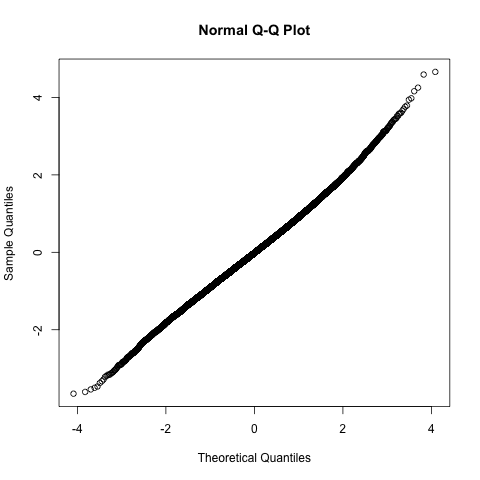

In [46]:
%%R -i peri_binned -o peri_within_anova -o peri_within_model
m <- lmer('df ~ 1+ factor(day)*bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=peri_binned)
peri_within_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
peri_within_anova <- anova(m)

In [47]:
peri_within_anova['Significance'] = peri_within_anova['Pr(>F)'].apply(check_significance)
peri_within_model['Significance'] = peri_within_model['Pr(>|t|)'].apply(check_significance)


display(peri_within_anova, peri_within_model)

supp_train_fig_peri_stats.update({'peri_within_anova': peri_within_anova,
                                  'peri_within_model': peri_within_model
                                  })

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Significance
factor(day),1.064611,0.532306,2,22767.632511,0.608818,5.440024e-01,ns
bout_fraction,0.128372,0.128372,1,22777.017999,0.146824,7.015926e-01,ns
factor(cs),0.949939,0.949939,1,22772.844376,1.086481,2.972633e-01,ns
"bs(bins, df = 8, degree = 3)",54.430783,6.803848,8,20.652109,7.781817,8.387678e-05,****
factor(day):bout_fraction,2.466679,1.233340,2,22777.013396,1.410617,2.440141e-01,ns
factor(day):factor(cs),0.633778,0.316889,2,22761.634340,0.362438,6.959816e-01,ns
bout_fraction:factor(cs),0.494343,0.494343,1,22777.016453,0.565398,4.521011e-01,ns
"factor(day):bs(bins, df = 8, degree = 3)",25.355455,1.584716,16,22747.255789,1.812499,2.400070e-02,*
"bout_fraction:bs(bins, df = 8, degree = 3)",102.861197,12.857650,8,22777.021766,14.705777,1.162882e-21,****
"factor(cs):bs(bins, df = 8, degree = 3)",13.684791,1.710599,8,22764.825927,1.956476,4.769665e-02,*


,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
(Intercept),0.112457,0.157984,573.386333,0.711823,0.476864,ns
factor(day)2,-0.205737,0.211856,22737.705479,-0.971118,0.331500,ns
factor(day)3,-0.146443,0.213346,22747.931766,-0.686411,0.492461,ns
bout_fraction,-0.076593,0.260186,22776.860429,-0.294376,0.768473,ns
factor(cs)+,0.007264,0.222793,22738.358097,0.032602,0.973992,ns
...,...,...,...,...,...,...
"factor(day)3:bout_fraction:factor(cs)+:bs(bins, df = 8, degree = 3)6",-1.730108,0.920766,22777.011086,-1.878988,0.060259,ns
"factor(day)2:bout_fraction:factor(cs)+:bs(bins, df = 8, degree = 3)7",0.413810,0.927963,22777.024691,0.445934,0.655649,ns
"factor(day)3:bout_fraction:factor(cs)+:bs(bins, df = 8, degree = 3)7",0.995420,0.928707,22777.020047,1.071835,0.283806,ns
"factor(day)2:bout_fraction:factor(cs)+:bs(bins, df = 8, degree = 3)8",0.059383,0.738842,22777.019747,0.080374,0.935941,ns


In [48]:
with pd.ExcelWriter('stats/raw/supp_train_peri_stats.xlsx') as writer:  
    for k,v in supp_train_fig_peri_stats.items():
        v.to_excel(writer, sheet_name=k)

# Testing

In [51]:
#reload the data without normalizing
testing = analysis(norm_method, t_dur, norm = False,
                    ds_freq = ds_freq, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
testing.load_append_save(cohort1_data_dir/'testing.npy', log=False)
testing.load_append_save(cohort2_data_dir/'testing.npy', log=False)
for i in mice_to_drop:
    testing.remove_mouse(i, recompute = False)

testing.compute()
    
# remove timestamps corresponding to datapoints that will be lost to the moving average
old_t = testing.all_490.index.values
new_t = old_t[int(ds_freq * w_rad):-int(ds_freq *w_rad)]

# estimate baseline with a moving average
bl = testing.all_490.apply(lambda x: pd.Series(signal.convolve(x, kernel, mode='valid'), index = new_t), axis=0)

# update the end and start time fields in the analysis object
testing.t_prestim = -new_t[0]
testing.t_endrec = new_t[-1]
testing.all_490 = testing.all_490.loc[bl.index]

# normalize relative to the baseline
testing.all_490 = (testing.all_490.copy() - bl)/bl

# #z-score ∆F/Fs relative to baseline activity for each session
testing.all_490 = (testing.all_490 - testing.all_490.loc[:0].mean(axis=0))/testing.all_490.loc[:0].std(axis=0)

recomputing...
successful


In [52]:
# compute lick bout times for testing
np.random.seed(99)

setup = pd.read_csv(os.path.join(data_dir,'setup.csv'), index_col = 0)
for i,v in testing.raw_data.items():
    day = i[0][-1]
    mouse = i[1]
    
    # use setup file to identify left v right licks as cs+ v cs- licks
    csp_s = setup.loc[mouse, f'd{day}_side']
    csm_s = 'left' if csp_s == 'right' else 'right'
    testing.raw_data.loc[i].events['csp'] = v.events[csp_s + '_licks']
    testing.raw_data.loc[i].events['csm'] = v.events[csm_s + '_licks']
    
    # combine cs+ and cs- lick times and construct an array of labels
    cspl = testing.raw_data.loc[i].events['csp']
    csml = testing.raw_data.loc[i].events['csm'] 
    all_licks = np.concatenate((cspl, csml))
    labels = np.array(['p']*cspl.size + ['m']*csml.size)
    
    # sort labels for all lick events so we can identify bouts later
    sort_idx = all_licks.argsort()
    labels = labels[sort_idx]
    all_licks = all_licks[sort_idx]
    
    # identify bout starts by thresholding the ili over all licks
    ili = np.append(bout_thresh + 1, all_licks[1:] - all_licks[:-1] )
    all_bouts = all_licks[ili>bout_thresh]
    
    # determine whether bouts were initiated by a cs+ or cs- lick
    all_bout_labels = labels[ili>bout_thresh]
    csp_bouts = all_bouts[all_bout_labels == 'p']
    csm_bouts = all_bouts[all_bout_labels == 'm']
    
    # update the field
    testing.raw_data.loc[i].events['all_csp_bouts'] = csp_bouts
    testing.raw_data.loc[i].events['all_csm_bouts'] = csm_bouts
    
    
    # remove bouts near the end that cannot be used for peri-bout analyses
    csp_bn = get_bn(testing.raw_data.loc[i], 'csp', 'all_csp_bouts').values
    csp_bouts = csp_bouts[csp_bn>1]
    csp_bouts = csp_bouts[csp_bouts<testing.t_endrec - peri_window - 1]
    
    csm_bn = get_bn(testing.raw_data.loc[i], 'csm', 'all_csm_bouts').values
    csm_bouts = csm_bouts[csm_bn>1]
    csm_bouts = csm_bouts[csm_bouts<testing.t_endrec - peri_window - 1]
    
    testing.raw_data.loc[i].events['csp_bouts'] = csp_bouts
    testing.raw_data.loc[i].events['csm_bouts'] = csm_bouts
    
    testing.raw_data.loc[i].events['all_bouts'] = all_bouts  

In [53]:
# check how many bouts we are removing due to the moving average
max_rm_bouts = testing.raw_data.map(lambda x: (x.events['all_bouts']>testing.t_endrec).sum()).max()
mn_rm_bouts = testing.raw_data.map(lambda x: (x.events['all_bouts']>testing.t_endrec).sum()).mean()
print('max removed bouts:', max_rm_bouts , '\nmn_rm_bouts:', mn_rm_bouts)

max removed bouts: 1 
mn_rm_bouts: 0.35714285714285715


In [54]:
# # get peri-bout activity for all cs+ and cs- bouts
    
csp_bout = peri_event(testing, 'csp_bouts', peri_window, norm = peri_bout_norm_test).T
csm_bout = peri_event(testing, 'csm_bouts', peri_window, norm = peri_bout_norm_test).T

# combine into one dataframe
peri_test = pd.concat({'+':csp_bout, '-':csm_bout}, names = ['cs'])
peri_test.columns.name = 'time'

# some reformatting for easier access
peri_test = peri_test.stack().rename('df').reset_index()
peri_test['day'] = peri_test.cond.str.extract('_(.)').astype(int)
peri_test = peri_test.set_index(['day','cs','mouse', 'event', 'time']).df.unstack('time')

# select only mice that had at least 3 bouts for each flavor on both days
nb_test = peri_test.groupby(['cs','day','mouse']).size().unstack(['cs','day'])
good_mice = (nb_test>=3).all(axis=1)
good_mice = good_mice.loc[good_mice].index
nb_test = nb_test.loc[good_mice].stack(['cs','day'])
peri_test = (peri_test.swaplevel('day','mouse')
                      .loc[good_mice]
                      .swaplevel('day','mouse')
            )

# get mean response
mn_peri_test = peri_test.groupby(['day','cs','mouse']).mean()
mn_peri_test = (mn_peri_test.unstack(['day','cs'])
                            .dropna()
                            .stack(['cs', 'day'])
                            .swaplevel('mouse','day')
                            .sort_index()
               )

In [55]:

# seed the random number generator for random bout generation
np.random.seed(5)

# simmulate random lick bouts and get corresponding peri bout activity
ctl_test = []

with tqdm(total = niters_rand) as pbar:
    def randomize_test_bouts(pid):
        global ctl_test
        global testing
        end_lim = testing.all_490.index[-1]-peri_window-1
        for i,v in testing.raw_data.items():
            # create an array of times to sample
            ts = np.arange(0, end_lim + 1/100, step = 1/100)
            n = v.events['all_bouts'].size # get the number of bouts to sample
            rand_evs = np.empty((n,))
            for j in range(n):
                #choose a bout onset time from available times
                rand_evs[j] = np.random.choice(ts)
                # remove the selected time from avavilable times array
                # as well as any times within the bout threshold
                ts = ts[np.abs(ts - rand_evs[j]) > bout_thresh]  
            rand_evs = np.sort(rand_evs) 
            # sample appropriate number of cs+ bouts
            csp = np.random.choice(rand_evs, v.events['all_csp_bouts'].size, replace = False)
            rand_evs = rand_evs[~np.isin(rand_evs, csp)]
            csp = np.random.choice(csp, v.events['csp_bouts'].size, replace = False)

            # sample appropriate number of cs- bouts
            csm = np.random.choice(rand_evs, v.events['all_csm_bouts'].size, replace = False)
            csm = np.random.choice(csm, v.events['csm_bouts'].size, replace = False)

            #save randomized bouts
            testing.raw_data.loc[i].events[f'rand_csp_{pid}'] = csp
            testing.raw_data.loc[i].events[f'rand_csm_{pid}'] = csp

        # get peri-bout data for random bouts and compute the mean response
        _d = pd.concat({'+': peri_event(testing, f'rand_csp_{pid}',  
                                        peri_window, 
                                        norm = peri_bout_norm_test).groupby(['cond','mouse'], axis=1).mean(),
                        '-': peri_event(testing, f'rand_csm_{pid}', 
                                        peri_window, 
                                        norm = peri_bout_norm_test).groupby(['cond','mouse'], axis=1).mean()
                       }, names = ['cs','time'])
        

        ctl_test.append(_d)


    with ThreadPoolExecutor(max_workers=2) as pool:
        futures = [pool.submit(randomize_test_bouts, i) for i in range(niters_rand)]
        for future in as_completed(futures):
            pbar.update(1)
        
ctl_test = pd.concat(dict(enumerate(ctl_test)), axis=1, names = ['event'])
ctl_test = ctl_test.unstack('cs').T.reset_index()
ctl_test['day']= ctl_test.cond.str.extract('_(.)').astype(int)
ctl_test=ctl_test.set_index(['day','cs','mouse','event']).drop('cond', axis=1).sort_index()
ctl_test_mn = ctl_test.groupby(['day','cs','mouse']).mean()


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.36it/s]


### further quantification

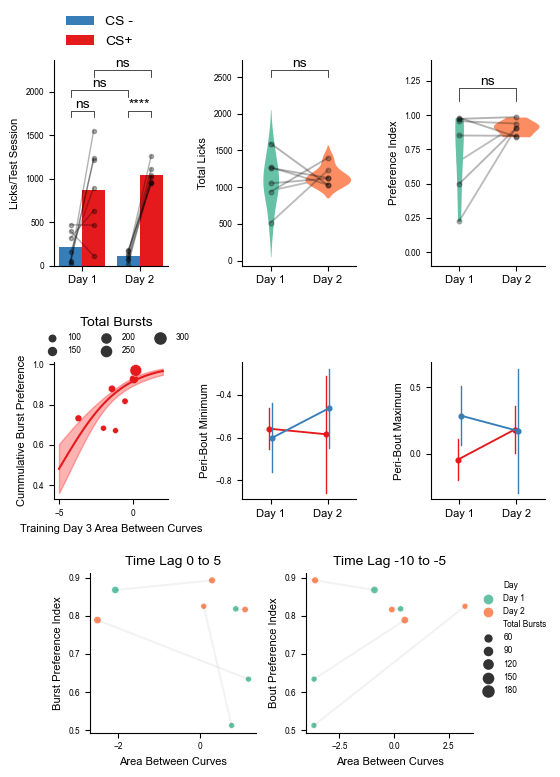

In [62]:
def get_cs_licks(x):
    x = x.iloc[0]
    return pd.Series([x.events['csp'].size, x.events['csm'].size], 
                     index = pd.Index(('+', '-'), name = 'cs'))
def get_cs_bursts(x):
    x = x.iloc[0]
    csp_ili = np.append(1, x.events['csp'][1:] - x.events['csp'][:-1])
    csm_ili = np.append(1, x.events['csm'][1:] - x.events['csm'][:-1])
    return pd.Series([(csp_ili>0.5).sum(), (csm_ili>0.5).sum()], 
                     index = pd.Index(('+', '-'), name = 'cs'))

# get testing licks for plot
licks_test_d = testing.raw_data.groupby(['cond','mouse']).apply(get_cs_licks).rename('licks').reset_index().rename(columns = {'cs': 'CS'})
licks_test_d['day'] = licks_test_d.cond.str.split('_',expand = True)[1].astype(int)
licks_test_d = licks_test_d.set_index(['day','mouse','CS']).licks.rename('total_licks')


# get testing bursts
burst_test_d = testing.raw_data.groupby(['cond','mouse']).apply(get_cs_bursts).rename('bursts').reset_index().rename(columns = {'cs': 'CS'})
burst_test_d['day'] = burst_test_d.cond.str.split('_',expand = True)[1].astype(int)
burst_test_d = burst_test_d.set_index(['day','mouse','CS']).bursts.rename("bursts")
day_df = pd.concat({'pref': burst_test_d.unstack("CS")['+']/(burst_test_d.unstack("CS")['+'] + burst_test_d.unstack("CS")['-']),
                    'tot': burst_test_d.unstack("CS")['+'] + burst_test_d.unstack("CS")['-']}, axis=1)

cumm_pref = burst_test_d.unstack('CS').groupby(['mouse']).sum().apply(lambda x: x['+']/(x['+']+x['-']), axis=1)
tot = burst_test_d.unstack('CS').groupby(['mouse']).sum().apply(lambda x: (x['+']+x['-']), axis=1)


# get the min from 0-5
mn_loc =  mn_peri_test.groupby(['day','cs']).mean().T.loc[0:5].idxmin(axis=0)
mn_rp_test_post = {}
for i,v in mn_loc.items():
    tmp = mn_peri_test.loc[i].T
    tmp.index = tmp.index.astype(float)
    mn_rp_test_post.update({i:tmp.loc[v-1:v+1].mean(axis=0)})
mn_rp_test_post = pd.DataFrame(mn_rp_test_post).T
mn_rp_test_post.index = mn_rp_test_post.index.set_names(['day', 'cs'])
mn_rp_test_post = mn_rp_test_post.stack().rename('df')


# get the max from -10- -5
mx_loc =  mn_peri_test.groupby(['day','cs']).mean().T.loc[-10:-5].idxmax(axis=0)
mx_rp_test = {}
for i,v in mx_loc.items():
    tmp = mn_peri_test.loc[i].T
    tmp.index = tmp.index.astype(float)
    mx_rp_test.update({i:tmp.loc[v-1:v+1].mean(axis=0)})
mx_rp_test = pd.DataFrame(mx_rp_test).T
mx_rp_test.index = mx_rp_test.index.set_names(['day', 'cs'])
mx_rp_test= mx_rp_test.stack().rename('df')


# get areas between curves
day_df['abc_10_5'] = (mn_peri_test.T.loc[-10:-5].T.stack().unstack('cs')
                                  .apply(lambda x: x['+'] - x['-'], axis=1)
                                  .unstack('time')
                                  .apply(lambda x: np.trapz(x=x.index, y=x), axis=1)
                                  .rename('abc')
                     )
day_df['abc_0_5'] = (mn_peri_test.T.loc[0:5].T.stack().unstack('cs')
                                  .apply(lambda x: x['+'] - x['-'], axis=1)
                                  .unstack('time')
                                  .apply(lambda x: np.trapz(x=x.index, y=x), axis=1)
                                  .rename('abc')
                     )



# create subplot
fig,ax = plt.subplots(3,3, figsize = (6,8), gridspec_kw = {'height_ratios': [1.5,1,1]})
# plot testing licks on each day
_, stats_2b  = two_bottle_plot(licks_test_d.loc[2].to_frame(), licks_test_d.loc[1].to_frame(), 
                               groups = ['Day 2', 'Day 1'], ax=ax[0,0], all_paired = True,
                               palette = sns.color_palette('Set1',2), ms=3, lw=1)
for i in ax[0,0].get_yticklabels():
    i.set_fontsize(6)
for i in ax[0,0].get_xticklabels():
    i.set_fontsize(8)
ax[0,0].set_ylabel("Licks/Test Session", fontsize = 8)


# plot total testing bursts
tmp = licks_test_d.unstack('CS').sum(axis=1).unstack('day')
ttest_res = st.ttest_rel(tmp[1], tmp[2])
cumm_stat = pd.DataFrame({'paired ttest': list(ttest_res) + [ttest_res.df]}, index= ('t', 'p-value', 'df')).T
tmp = tmp.stack('day').rename('tot').reset_index()
sns.pointplot(data = tmp, x = 'day', y = 'tot',
              hue = 'mouse', color='k', ax = ax[0,1], scale= .5)
plt.setp(ax[0,1].lines, alpha=.3)
plt.setp(ax[0,1].collections, alpha=.3)
plot_significance(cumm_stat['p-value'].iloc[0], ax[0,1], 0, 1, 2500, 100 )
sns.violinplot(data = tmp, x = 'day', y = 'tot',  ax = ax[0,1], linewidth=0, saturation = 1, palette = 'Set2')
ax[0,1].get_legend().remove()
ax[0,1].set_xticks([0,1])
ax[0,1].set_xticklabels(['Day 1', 'Day 2'], fontsize = 8)
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel("Total Licks", fontsize=8 )
for i in ax[0,1].get_yticklabels():
    i.set_fontsize(6)

# plot preference indices on each day
tmp = licks_test_d.unstack('CS')
tmp = tmp['+']/(tmp['+'] + tmp['-'])
tmp = tmp.unstack('day')
pref_stat = pd.DataFrame({'signed rank': st.wilcoxon(tmp[1], tmp[2])}, index= ('W', 'p-value')).T
tmp = tmp.stack('day').rename('pref').reset_index()
sns.pointplot(data = tmp, x = 'day', y = 'pref',
              hue = 'mouse', color='k', ax = ax[0,2], scale= .5)
plt.setp(ax[0,2].lines, alpha=.3)
plt.setp(ax[0,2].collections, alpha=.3)
plot_significance(pref_stat['p-value'].iloc[0], ax[0,2], 0, 1, 1.1, .1 )
sns.violinplot(data = tmp, x = 'day', y = 'pref',  ax = ax[0,2], linewidth=0, saturation = 1, palette = 'Set2', cut=0)
ax[0,2].set_ylim([-.1,1.4])
ax[0,2].get_legend().remove()
ax[0,2].set_xticks([0,1])
ax[0,2].set_xticklabels(['Day 1', 'Day 2'], fontsize = 8)
ax[0,2].set_xlabel('')
ax[0,2].set_ylabel("Preference Index", fontsize=8)
for i in ax[0,2].get_yticklabels():
    i.set_fontsize(6)


# plot pref vs train day 3 response
df = pd.concat({'preference':cumm_pref ,'training_day3_diff': diff_d3.loc[cumm_pref.index], 'total_bursts': tot})
sns.scatterplot(df, x='training_day3_diff', y='preference', size='total_bursts', ax=ax[1,0])
train_v_pref_model = smf.glm("preference ~ training_day3_diff", data = df, family = sm.families.Binomial(), freq_weights = df.total_bursts).fit()
x = np.linspace(-5, 2, 100)
pred = train_v_pref_model .get_prediction({'training_day3_diff': x})
ax[1,0].plot(x, pred.predicted_mean)
ax[1,0].fill_between(x, pred.conf_int()[:,0], pred.conf_int()[:,1],alpha=0.3, color='red')
ax[1,0].legend(frameon=False, title = 'Total Bursts', ncols=3, bbox_to_anchor=(-.15,1),loc='lower left', fontsize = 6)
ax[1,0].set_ylabel(r"Cummulative Burst Preference", fontsize=8)
ax[1,0].set_xlabel("Training Day 3 Area Between Curves", fontsize=8)
for i in ax[1,0].get_xticklabels() +  ax[1,0].get_yticklabels():
    i.set_fontsize(6)



# plot minimum peri response on each day
sns.pointplot(mn_rp_test_post.reset_index(), x='day', y='df',hue='cs',
              errorbar='se',dodge=True, ax=ax[1,1], scale = .5, errwidth=1)
ax[1,1].get_legend().remove()
ax[1,1].set_ylabel("Peri-Bout Minimum", fontsize=8)
ax[1,1].set_xticks([0,1])
ax[1,1].set_xticklabels(['Day 1', 'Day 2'], fontsize = 8)
ax[1,1].set_xlabel("")
for i in ax[1,1].get_yticklabels():
    i.set_fontsize(6)


# plot maximum peri response on each day
sns.pointplot(mx_rp_test.reset_index(), x='day', y='df',hue='cs',
              errorbar='se',dodge=True, ax=ax[1,2], scale = .5, errwidth=1)
ax[1,2].get_legend().remove()
ax[1,2].set_ylabel("Peri-Bout Maximum", fontsize=8)
ax[1,2].set_xticks([0,1])
ax[1,2].set_xticklabels(['Day 1', 'Day 2'], fontsize = 8)
ax[1,2].set_xlabel("")
for i in ax[1,2].get_yticklabels():
    i.set_fontsize(6)

# plot pref vs difference in cs+ and cs- tuning on each day
fig.tight_layout(pad = 2.)
ax[2,0].remove()
ax[2,1].remove()
ax[2,2].remove()
 
from matplotlib.gridspec import GridSpec
gs = GridSpec(3,14)
ax = fig.add_subplot(gs[2,1:6])

_day_df = day_df.reset_index()
_day_df['Day'] = 'Day ' + _day_df.day.astype('str')
_day_df = _day_df.rename(columns = {'tot': 'Total Lick Bursts'})
sns.lineplot(data = _day_df, x = 'abc_0_5', y = 'pref', hue = 'mouse', legend = False,
             palette = ["k"]* day_df.reset_index().mouse.unique().size, ax = ax, alpha=.05)
sns.scatterplot(data = _day_df, x = 'abc_0_5', y = 'pref', hue = 'Day', 
                ax = ax, palette = 'Set2', s=50, size = 'Total Lick Bursts')

h, l = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_title("Time Lag 0 to 5", fontsize=10)
ax.set_xlabel(r"Area Between Curves", fontsize=8)
ax.set_ylabel("Burst Preference Index", fontsize=8)
for i in ax.get_xticklabels() +  ax.get_yticklabels():
    i.set_fontsize(6)
    

ax = fig.add_subplot(gs[2,7:12])
_day_df = day_df.reset_index()
_day_df['Day'] = 'Day ' + _day_df.day.astype('str')
_day_df = _day_df.rename(columns = {'tot': 'Total Bursts'})
sns.lineplot(data = _day_df, x = 'abc_10_5', y = 'pref', hue = 'mouse', legend = False,
             palette = ["k"]* day_df.reset_index().mouse.unique().size, ax = ax, alpha=.05)
sns.scatterplot(data = _day_df, x = 'abc_10_5', y = 'pref', hue = 'Day', 
                ax = ax, palette = 'Set2', s=50, size = 'Total Bursts')
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, frameon = False, loc = 'upper left', bbox_to_anchor = (1,1), fontsize = 6)
ax.set_title("Time Lag -10 to -5", fontsize=10)
ax.set_xlabel(r"Area Between Curves", fontsize=8)
ax.set_ylabel("Bout Preference Index", fontsize=8)

for i in ax.get_xticklabels() +  ax.get_yticklabels():
    i.set_fontsize(6)

# format the figure
sns.despine()


# # save the figure
fig.savefig(os.path.join(peri_stim_pdfs_test ,'test_pref_quant.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_test ,'test_pref_quant.svg'))

<AxesSubplot: xlabel='maxdiff', ylabel='pref'>

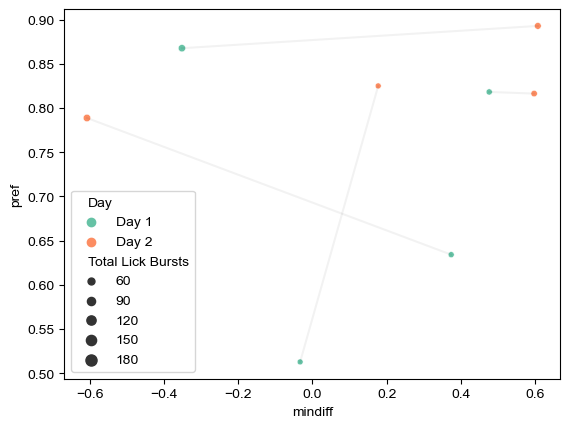

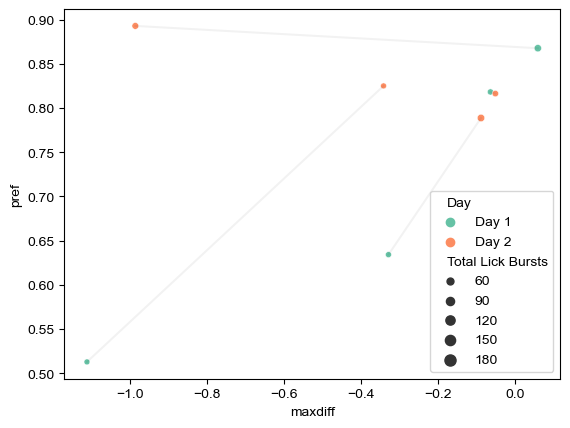

In [248]:

day_df['mindiff'] = (mn_peri_test.T.loc[0:].T.stack().unstack('cs')
                                  .groupby(['day','mouse']).min()
                                  .apply(lambda x: x['+'] - x['-'], axis=1)
                                  .rename('mindiff')
                     )
day_df['maxdiff'] = (mn_peri_test.T.loc[:0].T.stack().unstack('cs')
                                  .groupby(['day','mouse']).max()
                                  .apply(lambda x: x['+'] - x['-'], axis=1)
                                  .rename('mindiff')
                     )



_day_df = day_df.reset_index()
_day_df['Day'] = 'Day ' + _day_df.day.astype('str')
_day_df = _day_df.rename(columns = {'tot': 'Total Lick Bursts'})
sns.lineplot(data = _day_df, x = 'mindiff', y = 'pref', hue = 'mouse', legend = False,
             palette = ["k"]* day_df.reset_index().mouse.unique().size,  alpha=.05)
sns.scatterplot(data = _day_df, x = 'mindiff', y = 'pref', hue = 'Day', 
                palette = 'Set2', s=50, size = 'Total Lick Bursts')

plt.figure()
sns.lineplot(data = _day_df, x = 'maxdiff', y = 'pref', hue = 'mouse', legend = False,
             palette = ["k"]* day_df.reset_index().mouse.unique().size,  alpha=.05)
sns.scatterplot(data = _day_df, x = 'maxdiff', y = 'pref', hue = 'Day', 
                palette = 'Set2', s=50, size = 'Total Lick Bursts')


In [232]:
(mn_peri_test.T.loc[0:5].T.stack().unstack('cs')
                                  .groupby(['day','mouse']).min()
                                  .apply(lambda x: x['+'] - x['-'], axis=1)
                                  .rename('mindiff')
                     )

day  mouse 
1    adm484   -0.033192
     adm485    0.373739
     adm543    0.476155
     adm546   -0.531562
2    adm484   -0.058805
     adm485   -0.607504
     adm543    0.425921
     adm546    0.065212
Name: mindiff, dtype: float64

#### stats

##### stats - 2 bottle stats

In [63]:
shapiro = (licks_test_d.groupby(['day','CS'])
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
anova_res = AnovaRM(licks_test_d.reset_index(), 'total_licks',  'mouse', within = ['CS','day']).fit().summary().tables[0]
anova_res['Significance'] = anova_res['Pr > F'].apply(check_significance)
stats_2b = stats_2b.rename(columns = {'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value', 'statistic': 't'})
stats_2b['Significance'] = stats_2b['Corrected p-value'].apply(check_significance)
display(shapiro, anova_res, stats_2b)

main_test_fig_stats.update({'c_test_anova_g'   : anova_res,
                            'c_test_posthoc_g' : stats_2b})

statistic   p-value
day CS                     
1   +    0.972005  0.912507
    -    0.874941  0.204921
2   +    0.848672  0.119507
    -    0.960884  0.826282

,F Value,Num DF,Den DF,Pr > F,Significance
CS,47.019893,1.0,6.0,0.000474,***
day,0.172141,1.0,6.0,0.692643,ns
CS:day,0.936929,1.0,6.0,0.370450,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- Day 2,19.066858,0.000001,0.000005,6,True,****
CS+ vs. CS- Day 1,2.601278,0.040593,0.116901,6,True,ns
CS+ Day 2 vs. CS+ Day 1,0.775884,0.467289,0.716219,6,True,ns
CS- Day 2 vs. CS- Day 1,0.775884,0.467289,0.716219,6,True,ns


##### stats - cummulative licks comparison

In [64]:
cumm_stat['Significance'] = cumm_stat['p-value'].apply(check_significance)
display(cumm_stat)
main_test_fig_stats.update({'d_cumm_licks_d1v2': cumm_stat})

,t,p-value,df,Significance
paired ttest,-0.414899,0.692643,6.0,ns


##### stats - preference comparison

In [65]:
pref_stat['Significance'] = pref_stat['p-value'].apply(check_significance)
display(pref_stat)
main_test_fig_stats.update({'e_pref_d1v2': pref_stat})

,W,p-value,Significance
signed rank,8.0,0.375,ns


##### stats - training area between curves vs preference

In [66]:
train_v_pref = pd.DataFrame(train_v_pref_model.summary().tables[1]).astype(str)
train_v_pref.columns = train_v_pref.iloc[0].astype(str)
train_v_pref[''] = train_v_pref[''].astype(str)
train_v_pref = train_v_pref.iloc[1:].set_index('').astype(float)
train_v_pref['Significance'] = train_v_pref['P>|z|'].apply(check_significance)
display(train_v_pref)
main_test_fig_stats.update({'f_pref_v_train_abc_d3': train_v_pref})

,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,2.399,0.131,18.291,0.0,2.142,2.656,****
training_day3_diff,0.495,0.065,7.608,0.0,0.367,0.623,****


##### stats - minimum comparison

In [67]:
min_stats = pd.concat({'CS+ vs CS-': mn_rp_test_post.unstack('cs')
                                                    .groupby('day')
                                                    .apply(lambda x: st.ttest_rel(x['+'], x['-']))
                                                    .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                    .reset_index(),
                       'Day 1 vs Day 2': mn_rp_test_post.unstack('day')
                                                        .groupby('cs')
                                                        .apply(lambda x: st.ttest_rel(x[1], x[2]))
                                                        .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                        .reset_index()
                      }, names = ['Comparison']).droplevel(1).reset_index()
min_stats['Corrected p-value'] = multipletests(min_stats['p-value'], method = 'holm-sidak')[1]
min_stats['Significance'] = min_stats['Corrected p-value'].apply(check_significance)
main_test_fig_stats.update({'g_min_resp_d1v2': min_stats})
display(min_stats)

,Comparison,day,t,p-value,df,cs,Corrected p-value,Significance
0,CS+ vs CS-,1.0,0.256028,0.814481,3.0,NaN,0.974472,ns
1,CS+ vs CS-,2.0,-0.698357,0.535220,3.0,NaN,0.953335,ns
2,Day 1 vs Day 2,NaN,0.117235,0.914082,3.0,+,0.974472,ns
3,Day 1 vs Day 2,NaN,-0.415734,0.705552,3.0,-,0.974472,ns


##### stats - mean comparison

In [68]:
mean_stats = pd.concat({'CS+ vs CS-': mx_rp_test.unstack('cs')
                                                .groupby('day')
                                                .apply(lambda x: st.ttest_rel(x['+'], x['-']))
                                                .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                .reset_index(),
                       'Day 1 vs Day 2': mx_rp_test.unstack('day')
                                                   .groupby('cs')
                                                   .apply(lambda x: st.ttest_rel(x[1], x[2]))
                                                   .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                   .reset_index()
                      }, names = ['Comparison']).droplevel(1).reset_index()
mean_stats['Corrected p-value'] = multipletests(mean_stats['p-value'], method = 'holm-sidak')[1]
mean_stats['Significance'] = mean_stats['Corrected p-value'].apply(check_significance)
main_test_fig_stats.update({'h_mean_resp_d1v2': mean_stats})
display(mean_stats)

,Comparison,day,t,p-value,df,cs,Corrected p-value,Significance
0,CS+ vs CS-,1.0,-1.231735,0.305793,3.0,NaN,0.767750,ns
1,CS+ vs CS-,2.0,0.030851,0.977326,3.0,NaN,0.977818,ns
2,Day 1 vs Day 2,NaN,-0.944619,0.414542,3.0,+,0.799328,ns
3,Day 1 vs Day 2,NaN,0.204482,0.851064,3.0,-,0.977818,ns


##### stats - pref v diff model

In [241]:
df = day_df.reset_index()

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')



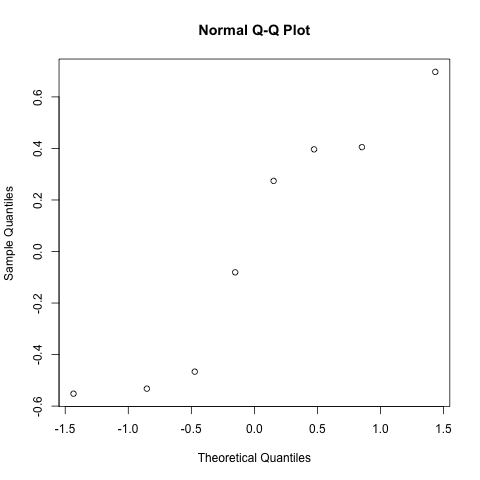

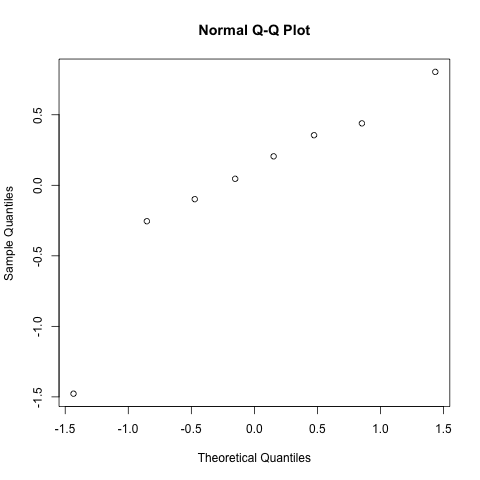

In [242]:
%%R -i df -o abc_0_5_model -o abc_10_5_model
m <- glmer('pref ~ 1 + mindiff*factor(day)  + (1 + mindiff|mouse)', data = df, weights = tot, family = 'binomial')
abc_0_5_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))

m <- glmer('pref ~ 1 + maxdiff*factor(day)  + (1 + maxdiff|mouse)', data = df, weights = tot, family = 'binomial')
abc_10_5_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))

In [238]:
abc_0_5_model['Significance'] = abc_0_5_model['Pr(>|z|)'].apply(check_significance)
abc_10_5_model['Significance'] = abc_10_5_model['Pr(>|z|)'].apply(check_significance)

display(abc_0_5_model, abc_10_5_model)

main_test_fig_stats.update({'i_abc_0_5_v_pref': abc_0_5_model,
                            'j_abc_10_5_v_pref': abc_10_5_model})

,Estimate,Std. Error,z value,Pr(>|z|),Significance
(Intercept),0.791354,0.433669,1.824790,0.068033,ns
mindiff,0.742974,1.112247,0.667994,0.504138,ns
factor(day)2,1.177448,0.535707,2.197931,0.027954,*
mindiff:factor(day)2,-1.311829,1.609919,-0.814841,0.415163,ns


,Estimate,Std. Error,z value,Pr(>|z|),Significance
(Intercept),1.515311,0.221463,6.842270,7.794795e-12,****
maxdiff,1.444683,0.359333,4.020454,5.808602e-05,****
factor(day)2,-0.192564,0.323862,-0.594587,5.521195e-01,ns
maxdiff:factor(day)2,-2.234093,0.640019,-3.490669,4.818132e-04,***


In [72]:
with pd.ExcelWriter('stats/raw/testing_stats.xlsx') as writer:  
    for k,v in main_test_fig_stats.items():
        v.to_excel(writer, sheet_name=k)

### (supplemental) - within day

In [73]:
peri_test_binned = bin_peri_bout(peri_test, 1).stack().rename('df').reset_index()
peri_test_binned['bout_fraction'] = peri_test_binned.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/x.max())
day1_test_binned = peri_test_binned.loc[peri_test_binned.day==1]

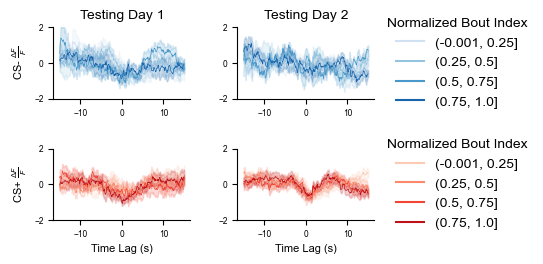

In [74]:
fig, ax = plt.subplots(2,2, figsize=(4.2,3))

df = peri_test.stack().rename('df').reset_index()
df['bout_fraction'] = df.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/(x.max()))
df['bout_frac_bin'] = pd.cut(df.bout_fraction, np.arange(0,1.001, 0.25), include_lowest=True)

for i in range(2):
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='-')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Blues', ax=ax[0,i], legend=False if i<1 else True, linewidth=0.5)
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='+')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Reds', markeredgewidth=0, ax = ax[1,i], legend=False if i<1 else True, linewidth=0.5)
    ax[0,i].set_ylim(-2,2)
    ax[1,i].set_ylim(-2,2)
    ax[0,i].set_title(f"Testing Day {i+1}", fontsize=10)
    ax[0,i].set_ylabel("")
    ax[1,i].set_ylabel("")
    ax[0,i].set_xlabel("")
    ax[1,i].set_xlabel("Time Lag (s)", fontsize=8)
    for j in ax[0,i].get_xticklabels() + ax[0,i].get_yticklabels():
        j.set_fontsize(6)
    for j in ax[1,i].get_xticklabels() + ax[1,i].get_yticklabels():
        j.set_fontsize(6)

ax[0,0].set_ylabel(r"CS- $\frac{\Delta F}{F}$", fontsize=8)
ax[1,0].set_ylabel(r"CS+ $\frac{\Delta F}{F}$", fontsize=8)
sns.despine()
fig.tight_layout(pad=2)


ax[0,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")
ax[1,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")

fig.savefig(os.path.join(peri_stim_pdfs_test ,'supp_test_within_session.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_test ,'supp_test_within_sessiont.svg'))

#### stats

R[write to console]: boundary (singular) fit: see help('isSingular')



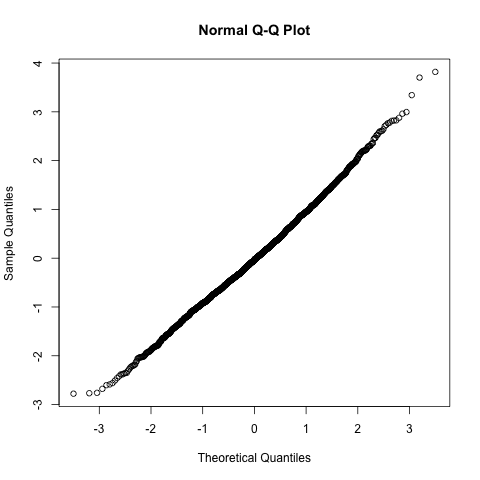

In [75]:
%%R -i day1_test_binned -o day1_test_anova -o day1_test_model
m <- lmer('df ~ 1+ bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=day1_test_binned)
day1_test_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
day1_test_anova <- anova(m)

In [76]:
day1_test_anova['Significance'] = day1_test_anova['Pr(>F)'].apply(check_significance)
day1_test_model['Significance'] = day1_test_model['Pr(>|t|)'].apply(check_significance)

display(day1_test_anova, day1_test_model)


supp_test_fig_peri_stats = {'day1_peri_bout_anovas': day1_test_anova,
                             'day1_peri_bout_stat':   day1_test_model}

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Significance
bout_fraction,0.879945,0.879945,1,2094.718583,0.933891,3.339655e-01,ns
factor(cs),0.859476,0.859476,1,2053.957587,0.912167,3.396525e-01,ns
"bs(bins, df = 8, degree = 3)",30.496184,3.812023,8,25.929525,4.045724,3.112008e-03,**
bout_fraction:factor(cs),0.005684,0.005684,1,2094.716301,0.006032,9.381002e-01,ns
"bout_fraction:bs(bins, df = 8, degree = 3)",20.022654,2.502832,8,2094.719132,2.656271,6.700930e-03,**
"factor(cs):bs(bins, df = 8, degree = 3)",67.744463,8.468058,8,2033.654488,8.987203,3.468545e-12,****
"bout_fraction:factor(cs):bs(bins, df = 8, degree = 3)",30.157246,3.769656,8,2094.718826,4.000759,1.007522e-04,***


,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
(Intercept),0.198453,0.355531,34.150526,0.558187,0.580358,ns
bout_fraction,0.305086,0.530340,2094.715072,0.575266,0.565173,ns
factor(cs)+,-0.393907,0.412436,2053.957587,-0.955074,0.339652,ns
"bs(bins, df = 8, degree = 3)1",0.703833,0.657007,668.451882,1.071273,0.284433,ns
"bs(bins, df = 8, degree = 3)2",0.078689,0.522938,267.299944,0.150474,0.880504,ns
"bs(bins, df = 8, degree = 3)3",1.069102,0.547432,88.792325,1.952940,0.053976,ns
"bs(bins, df = 8, degree = 3)4",-0.654612,0.493015,90.565026,-1.327773,0.187590,ns
"bs(bins, df = 8, degree = 3)5",-1.074578,0.513936,264.321017,-2.090881,0.037494,*
"bs(bins, df = 8, degree = 3)6",0.076761,0.631365,35.457536,0.121579,0.903919,ns
"bs(bins, df = 8, degree = 3)7",-1.146848,0.577606,235.080956,-1.985518,0.048249,*


R[write to console]: boundary (singular) fit: see help('isSingular')



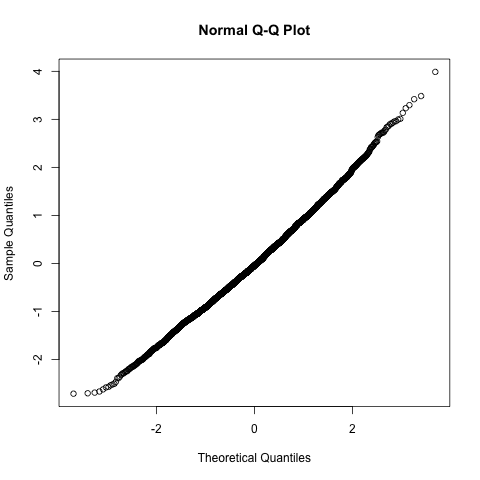

In [77]:
%%R -i peri_test_binned -o peri_within_test_anova -o peri_within_test_model
m <- lmer('df ~ 1+ factor(day)*bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=peri_test_binned)
peri_within_test_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
peri_within_test_anova <- anova(m)

In [78]:
peri_within_test_anova['Significance'] = peri_within_test_anova['Pr(>F)'].apply(check_significance)
peri_within_test_model['Significance'] = peri_within_test_model['Pr(>|t|)'].apply(check_significance)


display(peri_within_test_anova, peri_within_test_model)

supp_test_fig_peri_stats.update({'peri_within_anova': peri_within_test_anova,
                                  'peri_within_model': peri_within_test_model
                                  })

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Significance
factor(day),0.236899,0.236899,1,4382.199646,0.275116,5.999468e-01,ns
bout_fraction,1.301961,1.301961,1,4383.399991,1.511999,2.189003e-01,ns
factor(cs),0.000069,0.000069,1,4351.729274,0.000081,9.928344e-01,ns
"bs(bins, df = 8, degree = 3)",32.670442,4.083805,8,16.551633,4.742621,3.637483e-03,**
factor(day):bout_fraction,0.025781,0.025781,1,4383.396237,0.029940,8.626353e-01,ns
factor(day):factor(cs),1.118210,1.118210,1,4359.327410,1.298604,2.545310e-01,ns
bout_fraction:factor(cs),1.380178,1.380178,1,4383.397049,1.602834,2.055693e-01,ns
"factor(day):bs(bins, df = 8, degree = 3)",9.728452,1.216057,8,4382.654603,1.412236,1.857459e-01,ns
"bout_fraction:bs(bins, df = 8, degree = 3)",19.678805,2.459851,8,4383.401186,2.856684,3.617370e-03,**
"factor(cs):bs(bins, df = 8, degree = 3)",40.671785,5.083973,8,4355.353050,5.904140,1.525887e-07,****


,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
(Intercept),0.204952,0.312758,334.405483,0.655304,0.512723,ns
factor(day)2,-0.176403,0.469246,4376.577872,-0.375929,0.706988,ns
bout_fraction,0.305086,0.506988,4383.366651,0.601762,0.547364,ns
factor(cs)+,-0.329329,0.393514,4331.444647,-0.836894,0.402698,ns
"bs(bins, df = 8, degree = 3)1",0.691147,0.634443,470.185262,1.089376,0.276546,ns
...,...,...,...,...,...,...
"factor(day)2:bout_fraction:factor(cs)+:bs(bins, df = 8, degree = 3)4",1.005658,1.382873,4383.392191,0.727224,0.467128,ns
"factor(day)2:bout_fraction:factor(cs)+:bs(bins, df = 8, degree = 3)5",3.590757,1.490186,4383.366420,2.409604,0.016011,*
"factor(day)2:bout_fraction:factor(cs)+:bs(bins, df = 8, degree = 3)6",0.850740,1.663637,4383.398789,0.511374,0.609115,ns
"factor(day)2:bout_fraction:factor(cs)+:bs(bins, df = 8, degree = 3)7",2.115041,1.677984,4383.397706,1.260465,0.207569,ns


In [79]:
with pd.ExcelWriter('stats/raw/supp_test_peri_stats.xlsx') as writer:  
    for k,v in supp_test_fig_peri_stats.items():
        v.to_excel(writer, sheet_name=k)